Tommaso Peritore

In [1]:
#matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import matplotlib.colors as mcolors

#numpy
import numpy as np

#glob
import glob 

%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_theme(style='darkgrid')

#fit
from scipy.optimize import curve_fit

#variable
variables = ["total_energy","kinetic_energy", "potential_energy", "pressure", "temperature"]
labels = [  "$E^\star/N$",
	  	 	"$K^\star/N$",
            "$U^\star/N$",
            "$P^\star$", 
            "$T^\star$"]
titles = [  "Total internal energy per particle",
			 	"Kinetic energy per particle",
            "Potential energy per particle",
            "Pressure", 
            "Temperature"]
phase = ["Gas","Liquid","Solid"]
t_values = [1.2,1.1,0.8]
colors = ['lightseagreen', 'salmon', 'darkorchid']

# Exercise 06

In Statistical Mechanics the one-dimensional (1D) Ising Model is exactly resoluble. The Hamiltonian for a system of N spins with nearest neighbors interaction is given by (in the following I will assume units such that $\mu_B=1$ and $k_B=1$):

$$
H = 
-J\sum_{i=1}^N s_i s_{i+1}
-\frac{h}{2}\sum_{i=1}^N (s_i + s_{i+1}) 
$$

where $\{ s_i \}_{i=1,N}$ are spin variables taking values in $\{-1;1\}$, $J>0$ (ferromagnetic model),and with the assumption $s_{N+1} = s_{1}$.

The partition function for $N$ spins, $Z$, can be exactly computed and it turns out to be:

$$
Z=\sum_{\{ s_i \}} \exp \left( -\beta H\right) = \lambda_1^N + \lambda_2^N
$$

where
$\lambda_{1,2} = 
e^{\beta J} 
\cosh (\beta h) \pm \left[ e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J) \right]^{1/2}$, 
and where $\beta=\frac{1}{k_b T} = \frac{1}{T}$.
Once the partition function has been computed, the Helmholtz free energy is readly obtained as $A = -k_B T \ln Z$. All the thermodynamic quantities of interest can be deduced from $A$ or, equivalently, from $Z$.

## 6.1

Complete the NSL_simulator code to simulate a 1D Ising model with the Gibbs sampling algorithm (the Metropolis algorithm is already implemented) to sample the Boltzmann's weight $p(\{ s_i \}) = \exp(-\beta H)/Z$. Verify the possibility to restart from a previous spin configuration.

The code already computes the internal energy: $U(N,T) = \left\langle H \right\rangle$. Add the calculation of $C(N,T)$, $\chi(N,T)$, $M(N,T,h)$ and compute:
1. $U(N,T) = \left\langle H \right\rangle_{h=0}$
2. $C(N,T) = k_B \beta^2 (\left\langle H^2 \rangle_{h=0}-\langle H \right\rangle_{h=0}^2)$ 
3. $\chi(N,T) = \beta \left\langle (\sum_{i=1}^N s_i)^2 \right\rangle_{h=0}$
4. $M(N,T,h=0.02)= \left\langle \sum_{i=1}^N s_i \right\rangle_{h=0.02}$

as a function of $T$ in the range $\left[0.5;2.0\right]$ for a system of $N=50$ spins with $J=1$.

As usual, use data blocking and give an estimate of the statistical uncertainties.

- Show pictures of your estimations of $U(N,T)$, $C(N,T)$, $\chi(N,T)$, $M(N,T,h=0.02)$ and their uncertainties obtained with a large number of *MC steps* (e.g. $M\ge 10^5$) compared with the exact curves. In the same picture show your results obtained with both sampling methods, Metropolis and Gibbs.

A Monte Carlo step will consist in trying to flip one time all the spins of the system. Do not forget to equilibrate your simulations and to use blocking average with blocks large enough.

## Solution

### Ising model
The Ising model is a physical model that describes a system of spins positioned at the nodes of an N-dimensional lattice, where each spin can take discrete values of $\pm 1$.

The spins interact with each other, generally limited to the nearest neighbors, through an exchange force that favors the alignment of parallel spins and the anti-alignment of antiparallel spins. The energy of the system therefore depends on the orientation of each spin: when one of these is flipped, the energy of the system changes, depending on the orientation of the adjacent spins.

The Ising model is characterized by a temperature parameter that effectively regulates the intensity of the interaction between the particles. At low temperatures, the exchange energy dominates and the system tends to form regions of parallel spins, i.e., to magnetize. At high temperatures, the thermal energy tends to disorder the system and the magnetization tends to zero. In other words, the temperature affects the system's propensity to magnetize or not, depending on the extent of the interaction between the particles.

The one-dimensional Ising model is analytically solvable. Writing the Hamiltonian of the system as:

$$
H = 
-J\sum_{i=1}^N s_i s_{i+1}
-\frac{h}{2}\sum_{i=1}^N (s_i + s_{i+1}) 
$$

we can derive the partition function $Z$ which will have the following form:

$$
Z=\sum_{\{ s_i \}} \exp \left( -\beta H\right) = \lambda_1^N + \lambda_2^N
$$

with
$\lambda_{1,2} = 
e^{\beta J} 
\cosh (\beta h) \pm \left[ e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J) \right]^{1/2}$, 
and $\beta=\frac{1}{k_b T} = \frac{1}{T}$.

As is known from statistical mechanics, from the partition function we can derive:

- the **internal energy** per spin (with $h=0$):

$$
\frac{U(N,T)}{N} = \frac{\langle H \rangle}{N}
= \frac{1}{N} \sum_{\{ s_i \}} H \frac{\exp \left( -\beta H\right)}{Z}
= -\frac{1}{N}\frac{\partial \ln Z}{\partial \beta}
\underset{h=0}= -J \tanh (\beta J) \Biggl( \frac{1 + \tanh^{N-2} (\beta J)}{1+\tanh^N (\beta J)} \Biggl)
$$

- the **heat capacity** (with $h=0$):

$$
C(N,T) = \frac{\partial U(N,T)}{\partial T} = k_B\beta^2 \left(\langle H^2 \rangle -\langle H \rangle^2 \right)
\underset{h=0}= 
k_B N (\beta J)^2 \left\{ 1+\tanh^N (\beta J)+(N-1)\tanh^2 (\beta J)+(N-1)\frac{\tanh^{N-2} (\beta J)}{1+\tanh^N (\beta J)}
- N \left[ \frac{\tanh (\beta J) + \tanh^{N-1} (\beta J)}{1+\tanh^N (\beta J)} \right]^2 \right\}
$$

- the **magnetic susceptibility** (with $h=0$):

$$
\chi(N,T) = \frac{\partial M}{\partial h} = 
\frac{\partial}{\partial h}\sum_{\{ s_i \}} \left[ \sum_{i=1}^N s_i\right] \frac{\exp \left( -\beta H\right)}{Z}
= ... = 
\beta \left[ \left\langle \left( \sum_{i=1}^N s_i \right)^2 \right\rangle - \left\langle \sum_{i=1}^Ns_i \right\rangle^2 \right]
\underset{h=0}= \beta \left[ \left\langle \left( \sum_{i=1}^N s_i \right) ^2 \right\rangle \right] = \beta e^{2\beta J} \left( \frac{1-\tanh^N (\beta J)}{1+\tanh^N (\beta J)} \right)
$$

- the **magnetization** (with $h \not= 0$):

$$
M(N,T,h) = -\frac{\partial A}{\partial h} = \left\langle \sum_{i=1,N}s_i \right\rangle
$$

$$
\frac{M(N,T,h)}{N}=   \frac{k_B T}{N} \dfrac{\partial \ln Z}{\partial h} = \frac{e^{\beta J}\; \sinh(\beta h)}{Z} \; \left[\lambda_1^{N-1}\cdot \left(1+\frac{e^{\beta J}\; \cosh(\beta h)}{\sqrt{e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J)}}\right) + \lambda_2^{N-1}\cdot \left(1-\frac{e^{\beta J}\; \cosh(\beta h)}{\sqrt{e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J)}}\right)\right]
$$

If $h=0$ the magnetization $M(N,T,h=0)=\langle \sum_{i=1,N}s_i \rangle =0$ there are no interactions that induce the alignment of the spins and the system remains unmagnetized.



### Metropolis and Gibbs Sampling
The Boltzmann weight sampling algorithms I use are the Metropolis and Gibbs sampling methods, which determine how the spin configuration space is visited. The condition of constant temperature implies that the spin system in the 1D Ising model is in a *canonical ensemble*: that is, the system exchanges energy with a thermal bath with a much larger heat capacity compared to the system. This energy exchange allows, from a macroscopic point of view, to maintain the constant temperature of the system during the simulation. In other words, the spin system is in an environment that acts as a temperature regulator, ensuring that the system's temperature remains constant during the simulation.

Now I will show how the different algorithms work in this specific case:

- The **Metropolis algorithm** modifies the orientation of a randomly chosen spin, moving from configuration ($a$) to configuration($b$). The move is accepted with a certain probability $A(b|a)$, i.e. the probability of $b$ happening starting from a situation $a$, which depends on the energy difference ($\Delta E$) between the two configurations and the system's temperature $T$. Specifically, the move is always accepted if the new configuration $b$ is more probable than the previous configuration $a$, while it is accepted with probability $\exp{\left(-\beta \Delta E\right)}$ if $b$ is less probable than $a$. In formulas:
	$$ A(b|a) = \min{\left(1, \, \exp{\left[\beta \Delta E\right]} \right)}, $$
	where $\Delta E$  is the energy variation due to the spin-flip, considering that the interaction is limited to nearest neighbors.

- The **Gibbs algorithm**, on the other hand, randomly selects a spin from configuration $a$ and proposes a new value for it, independent of its value in configuration $a$, drawn from the conditional distribution defined by the neighboring spins:
	$$ p(s_{k}=\pm 1) = \frac{1}{1 + \exp{[\mp \beta \Delta E]}}, $$
	where $\Delta E$ is the energy difference between the configuration in which the $i$-th spin is up and the configuration in which the spin is down. This way, the Gibbs algorithm does not reject any attempt, making it more efficient than the Metropolis algorithm.

In summary, both the Metropolis and Gibbs algorithms are used to generate random spin configurations in the 1D Ising system at a given temperature. The Metropolis algorithm changes the orientation of a randomly chosen spin and accepts the move with a certain probability, while the Gibbs algorithm generates a new spin configuration by imposing the value of the selected spin.

The implementation of the two algorithms are implemented within the `move()` function of the `system.cpp` file is shown below:

```c++
if(_sim_type == 3) {      // Gibbs
  
  double delta_E = 2. * (_J * (_particle(this->pbc(i-1)).getspin() + _particle(this->pbc(i+1)).getspin()) + _H);
  double prob_i_up = 1. / (1. + exp (-1.*_beta * deltaE));
  
  if (_rnd.Rannyu() < prob_i_up) _particle(i).setspin(+1);
	
  else _particle(i).setspin(-1); 
	
  _naccepted ++;

} else if(_sim_type == 2){ // Metropolis 
	
  if(this->metro(i)){		
    _particle(i).flip();	
    _naccepted++;
  }
}
```
where the `metro(i)` function is defined as follows:

```c++
bool decision = false;
double delta_E, acceptance;

if(_sim_type == 1) delta_E = this->Boltzmann(i,true) - this->Boltzmann(i,false); 

else delta_E = 2.0 * _particle(i).getspin() * 
  ( _J * (_particle(this->pbc(i-1)).getspin() + _particle(this->pbc(i+1)).getspin() ) + _H ); 

acceptance = exp(-_beta*delta_E); 

if(_rnd.Rannyu() < acceptance ) decision = true;

return decision;
```

### Equilibration

To take care of equilibration, the following considerations were made.

Since we are looking at the evolution of macroscopic quantities such as the internal energy, the heat capacity, the magnetic susceptibility, and the magnetization, we need to ensure that the system has reached a stationary state before starting to collect data. This is because the system needs to explore the configuration space and reach a state of equilibrium before the macroscopic quantities can be considered reliable. However, we know that at high temperatures, the system is disordered and the magnetization tends to zero, while at low temperatures the system tends to magnetize. Therefore, the equilibration time will depend on the temperature at which the system is initialized. In particular, at low temperatures, the system will take longer to equilibrate, while at high temperatures the equilibration time will be shorter if we start from an initial random configuration.

To avoid having to equilibrate from a random initial configuration every time a new temperature was set, I implemented the possibility to restart the simulation from the last configuration of the previous temperature. This way, the system can start from a configuration that is already close to equilibrium, reducing the equilibration time. This is particularly useful when the temperature range is small, as the system will not have to explore the configuration space from scratch every time a new temperature is set.

Thus the initial configuration is randomly initialized only for the highest temperature of $T=2.5$ and from then on, the system is initialized with the last configuration of the previous temperature, saved at the end of each simulation. This proved to be very successful by looking into the configuration of spins as the temperature is lowered, since it was observed that the system is already in a state of equilibrium and the macroscopic quantities can be considered reliable from the beginning of the simulation.

### Comments on code

The general execution of the code is taken care of by the bash file execution.sh, which compiles the code and runs the simulations for the Metropolis and Gibbs sampling methods. In particular the script cycles over the temperatures in the range $[0.5,2.0]$ and for each temperature it runs the simulation for both sampling methods. It also takes care of running the simulation at first without external field, i.e. $h=0$, to compute the internal energy, the heat capacity and susceptibility, and then with an external field $h=0.02$ to compute the magnetization.

For details on how to run the code, please refer to the ReadMe file.

<br> The directory for this exercise is `./6.1` and is organized with main source code inside `_SOURCE`, input files `_INPUT` and results of the simulations are organized depending on the algorithm used for sampling in `_OUTPUT/GIBBS/` and `_OUTPUT/METROPOLIS/`.

The input file allow us to define the parameters of the simulation. Here is an example of one
>SIMULATION_TYPE $\quad$ 2  1.0  0.02  0
><br>TEMP $\qquad\qquad\qquad\qquad\quad\,\,$ 2.5
><br>RESTART $\qquad\qquad\qquad\qquad\,\,\,\,\,$ 0
><br>NPART $\qquad\qquad\qquad\qquad\quad\,$ 50
><br>RHO $\qquad\qquad\qquad\qquad\qquad$ 1.0
><br>NBLOCKS $\qquad\qquad\qquad\qquad$ 50
><br>NSTEPS $\qquad\qquad\qquad\,\,\,\,$ 100000
><br>
><br>ENDINPUT

Where the parameters are
- SIMULATION_TYPE: type of simulation, here with $2$ we run a METROPOLIS and with $3$ we run GIBBS; values for $_J$ and $_H$ and finally a boolean for equilibration. 
- TEMP: temperature to be initialized at the beginning of simulation.
- RESTART: boolean to tell the system whether to restart the simulation from a previously saved configuration. It is initialized to $0$ but the execution script will change it to $1$ if the simulation is not at the highest temperature.
- NPART: number of particles, here we have it set to $50$.
- RHO: density of the system. From here the volume and dimensions of the box are extracted.
- NBLOCKS: number of blocks.
- NSTEPS: number of steps per block.



### Results

Here below I show the results obtained for the internal energy, heat capacity, magnetic susceptibility and magnetization as a function of temperature for the 1D Ising model with $N=50$ spins and $J=1$. The results are compared with the exact curves obtained from the analytical solution of the model. The simulations were run with $10^5$ steps per block and $50$ blocks.

The results are shown for both the Metropolis and Gibbs sampling methods. The simulations were run for temperatures in the range $[0.5,2.0]$.

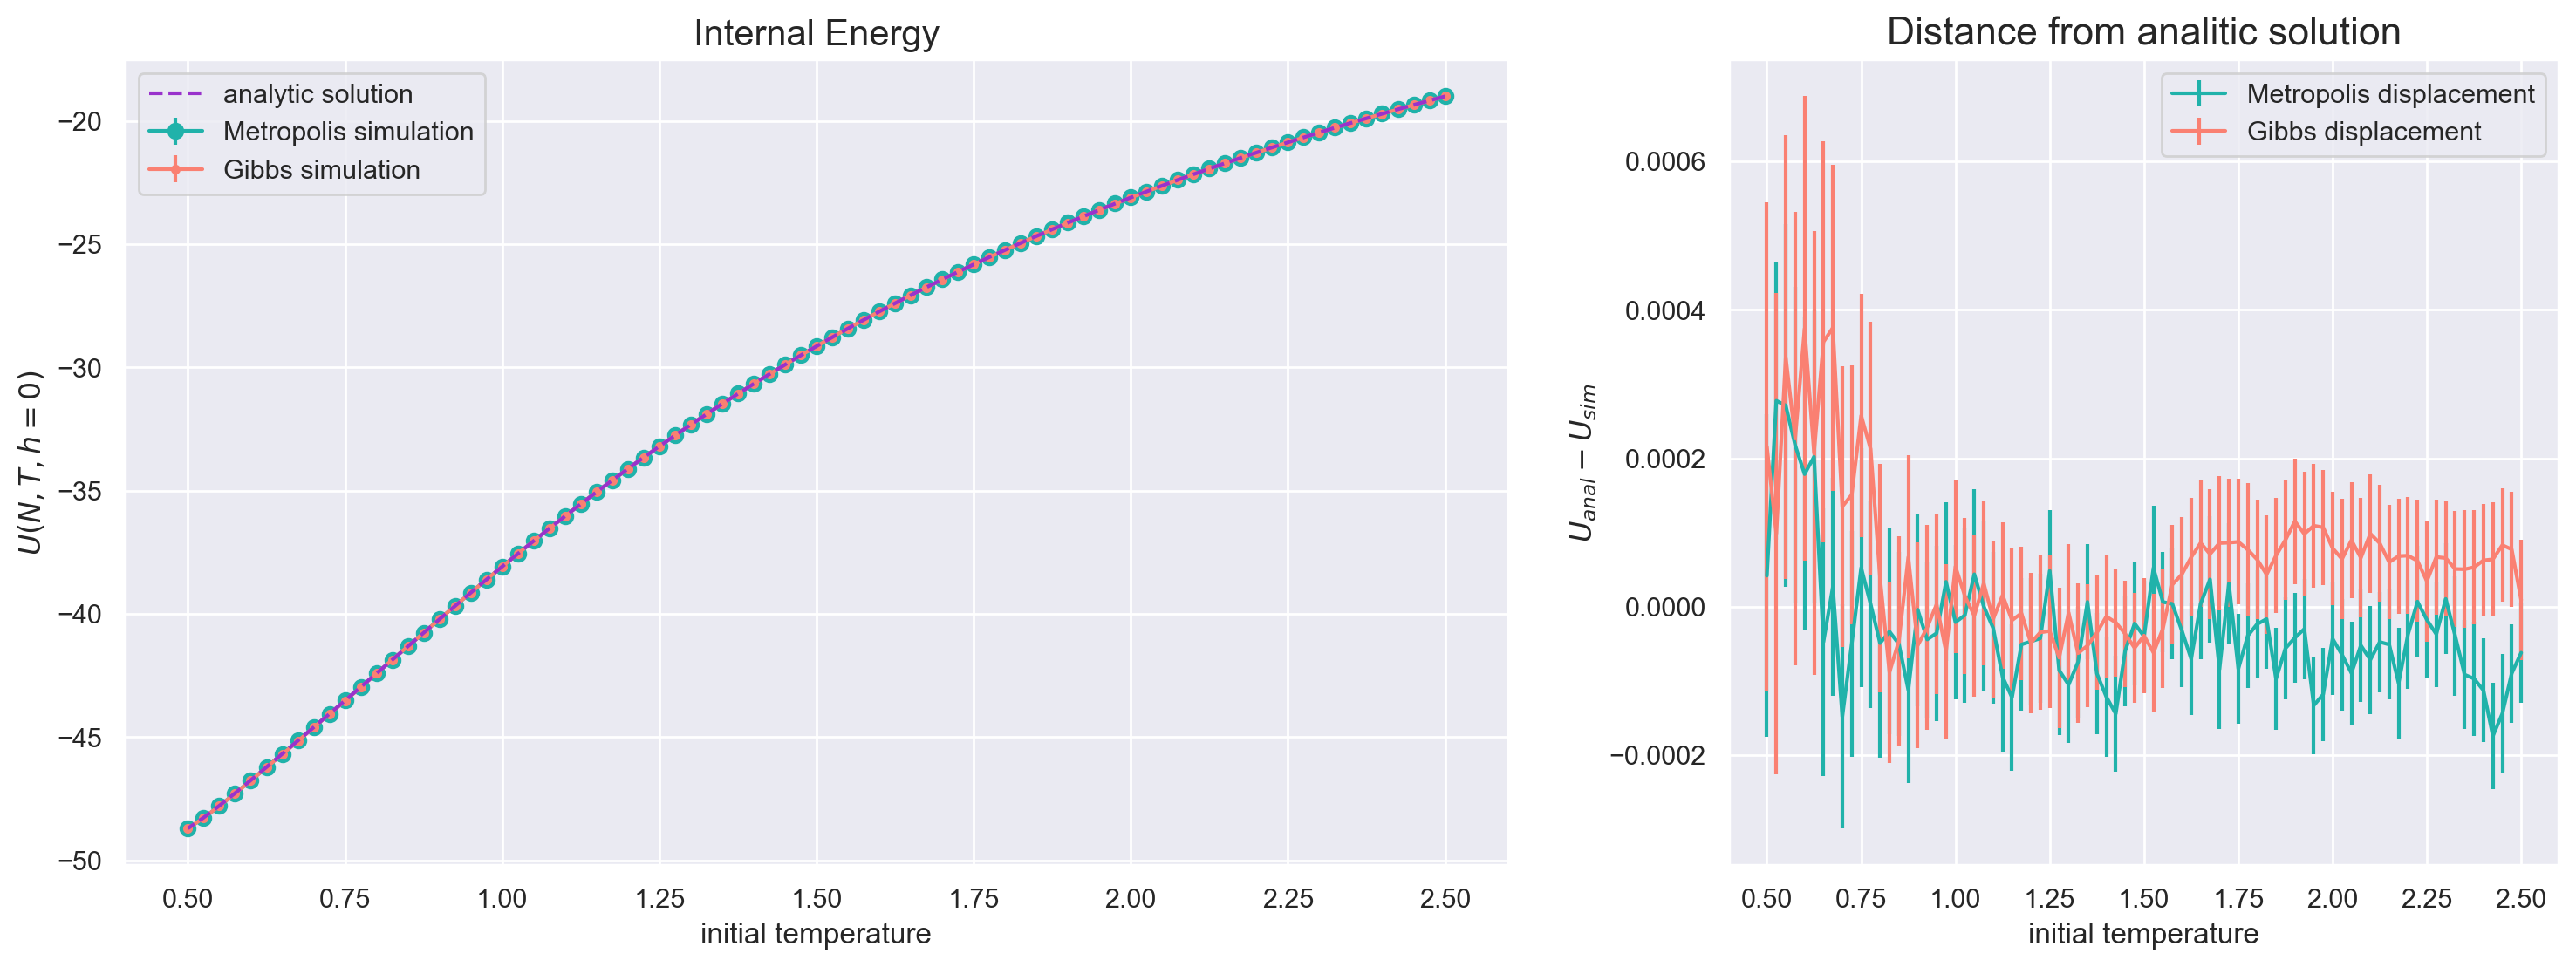

In [2]:
# Internal energy

T, final_value_MET, error_MET = np.loadtxt('./6.1/_OUTPUT/METROPOLIS/total_energy_0.00.dat', skiprows=1, unpack = True, usecols=(0, 1, 2))
final_value_GIB, error_GIB = np.loadtxt('./6.1/_OUTPUT/GIBBS/total_energy_0.00.dat', skiprows=1, unpack = True, usecols=(1, 2))


# Create a figure with 2 subplots, using width ratios of [2, 1.3] for the subplots
fig, axs = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [2, 1.2]}, figsize=(18,6))

# Plot data in the first subplot
axs[0].errorbar(T, 50*final_value_MET, yerr=error_MET,
					 color=colors[0], marker = 'o', label="Metropolis simulation")
axs[0].errorbar(T, 50*final_value_GIB, yerr=error_GIB,
					 color=colors[1], marker = '.', label="Gibbs simulation")
axs[0].grid(True)  # Add grid lines to the plot
axs[0].set_xlabel('initial temperature', fontsize=12)
axs[0].set_ylabel('$U(N,T,h=0)$', fontsize=12)
axs[0].set_title('Internal Energy', fontsize=15)

# Plot theoretical line
beta = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th
e = -J*( th + ch*thN )/( 1 + thN )
axs[0].plot(T, e*50, color=colors[2], label="analytic solution", linestyle='--', zorder=10)
axs[0].legend()

# axs[0].set_xlim(0.2,0.4)

# Plot data in the second subplot
axs[1].set_title(r'Distance from analitic solution', size = 16)
axs[1].errorbar(T, e - final_value_MET, yerr=error_MET, color=colors[0], label="Metropolis displacement")
axs[1].errorbar(T, e - final_value_GIB, yerr=error_GIB, color=colors[1], label="Gibbs displacement")

# style second subplot
axs[1].set_xlabel('initial temperature', size = 12)
axs[1].set_ylabel(r'$U_{anal}-U_{sim}$', size = 12)
axs[1].grid(True)
axs[1].legend()

# Show the plot
plt.show()

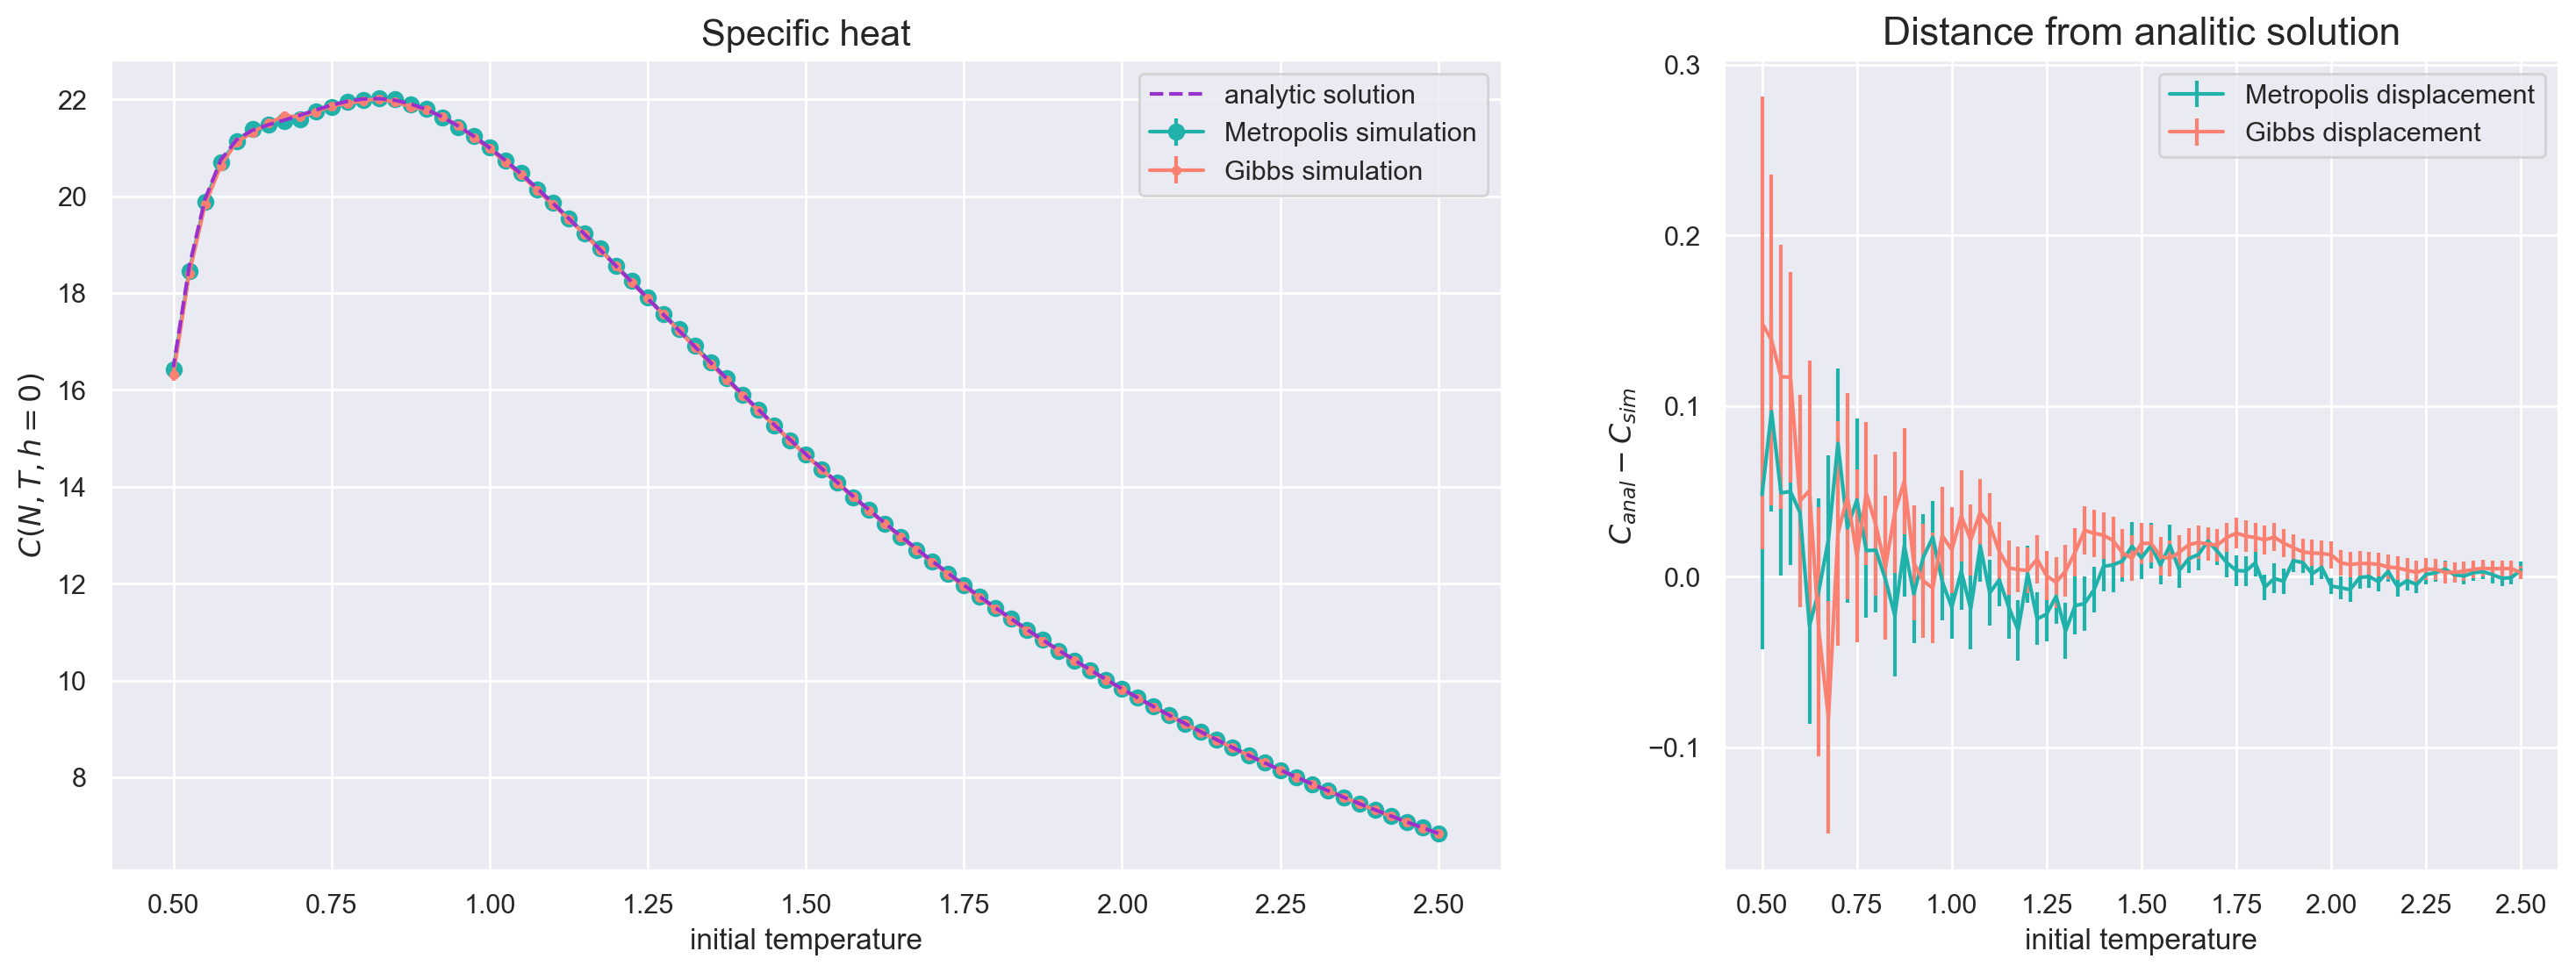

In [3]:
# specific heat

final_value_MET, error_MET = np.loadtxt('./6.1/_OUTPUT/METROPOLIS/specific_heat_0.00.dat', skiprows=1, unpack = True, usecols=(1, 2))
final_value_GIB, error_GIB = np.loadtxt('./6.1/_OUTPUT/GIBBS/specific_heat_0.00.dat', skiprows=1, unpack = True, usecols=(1, 2))

beta = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th
heat = 50*((beta*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)

# Create a figure with 2 subplots, using width ratios of [2, 1.3] for the subplots
fig, axs = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [2, 1.2]}, figsize=(18,6))

# Plot data in the first subplot
axs[0].errorbar(T, final_value_MET, yerr=error_MET,
					 color=colors[0], marker = 'o', label="Metropolis simulation")
axs[0].errorbar(T, final_value_GIB, yerr=error_GIB,
					 color=colors[1], marker = '.', label="Gibbs simulation")
axs[0].grid(True)  # Add grid lines to the plot
axs[0].set_xlabel('initial temperature', fontsize=12)
axs[0].set_ylabel('$C(N,T,h=0)$', fontsize=12)
axs[0].set_title('Specific heat', fontsize=15)
#axs[0].set_xlim(1.5,3.0)
#axs[0].set_ylim(-5,1)

# Plot theoretical line
axs[0].plot(T, heat, color=colors[2], label="analytic solution", linestyle='--', zorder=10)
axs[0].legend()

# axs[0].set_xlim(0.2,0.4)

# Plot data in the second subplot
axs[1].set_title(r'Distance from analitic solution', size = 16)
axs[1].errorbar(T, heat - final_value_MET, yerr=error_MET, color=colors[0], label="Metropolis displacement")
axs[1].errorbar(T, heat - final_value_GIB, yerr=error_GIB, color=colors[1], label="Gibbs displacement")

# style second subplot
axs[1].set_xlabel('initial temperature', size = 12)
axs[1].set_ylabel(r'$C_{anal}-C_{sim}$', size = 12)
axs[1].grid(True)
axs[1].legend()

# Show the plot
plt.show()

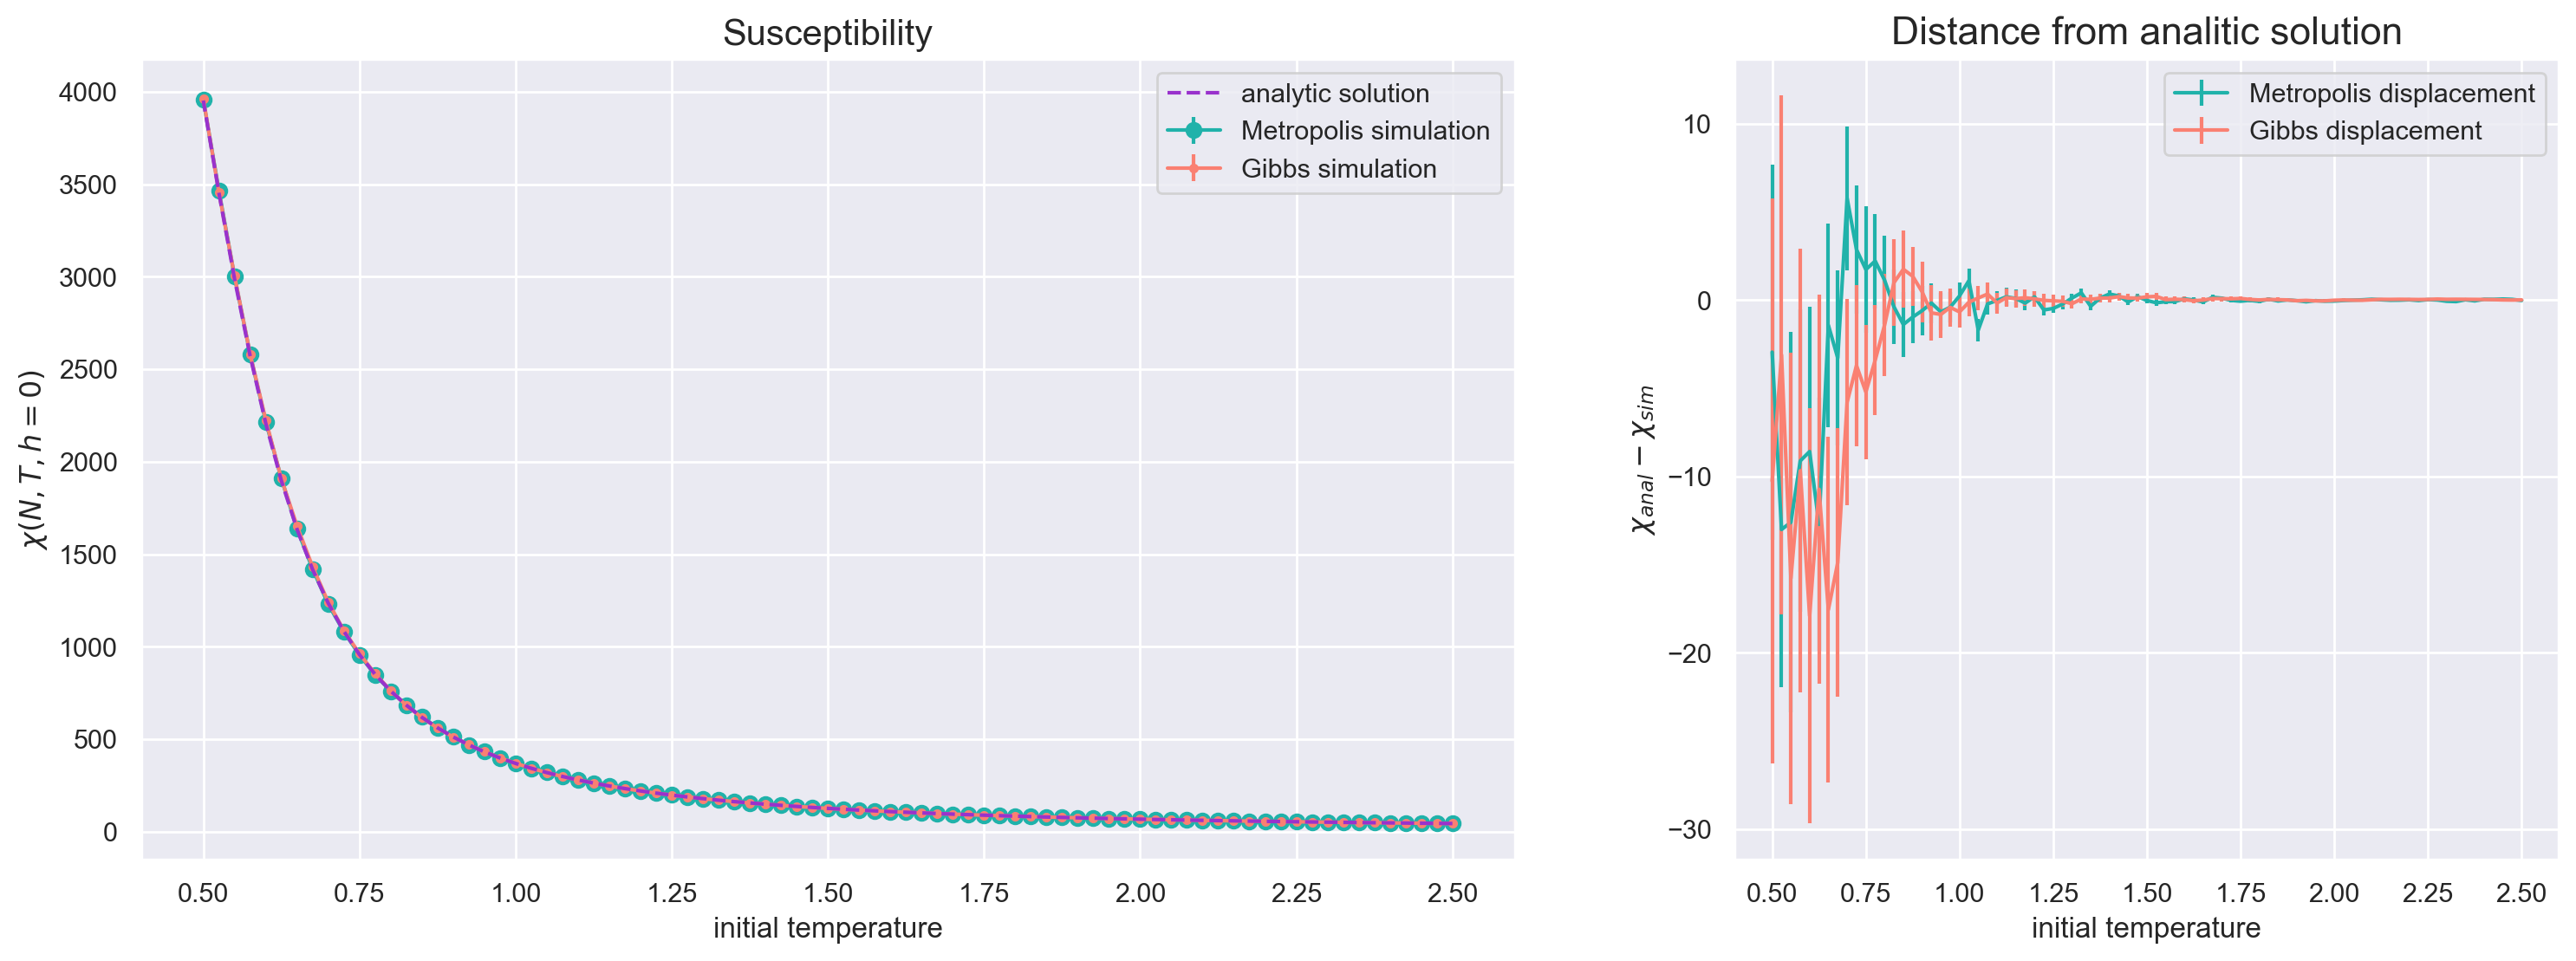

In [4]:
# susceptibility

final_value_MET, error_MET = np.loadtxt('./6.1/_OUTPUT/METROPOLIS/susceptibility_0.00.dat', skiprows=1, unpack = True, usecols=(1, 2))
final_value_GIB, error_GIB = np.loadtxt('./6.1/_OUTPUT/GIBBS/susceptibility_0.00.dat', skiprows=1, unpack = True, usecols=(1, 2))

h=0.02 #external field
b = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
X = 50*beta*np.exp(2*beta*J)*(1-thN)/(1+thN)

# Create a figure with 2 subplots, using width ratios of [2, 1.3] for the subplots
fig, axs = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [2, 1.2]}, figsize=(18,6))

# Plot data in the first subplot
axs[0].errorbar(T, final_value_MET, yerr=error_MET,
					 color=colors[0], marker='o', label="Metropolis simulation")
axs[0].errorbar(T, final_value_GIB, yerr=error_GIB,
					 color=colors[1], marker='.', label="Gibbs simulation")
axs[0].grid(True)  # Add grid lines to the plot
axs[0].set_xlabel('initial temperature', fontsize=12)
axs[0].set_ylabel('$\chi(N,T,h=0)$', fontsize=12)
axs[0].set_title('Susceptibility', fontsize=15)

# Plot theoretical line
axs[0].plot(T, X, color=colors[2], label="analytic solution", linestyle='--', zorder=10)
axs[0].legend()

# axs[0].set_xlim(0.2,0.4)

# Plot data in the second subplot
axs[1].set_title(r'Distance from analitic solution', size = 16)
axs[1].errorbar(T, X - final_value_MET, color=colors[0], yerr=error_MET, label="Metropolis displacement")
axs[1].errorbar(T, X - final_value_GIB, color=colors[1], yerr=error_GIB, label="Gibbs displacement")
# style second subplot
axs[1].set_xlabel('initial temperature', size = 12)
axs[1].set_ylabel(r'$\chi_{anal}-\chi_{sim}$', size = 12)
axs[1].legend()
axs[1].grid(True)

# Show the plot
plt.show()

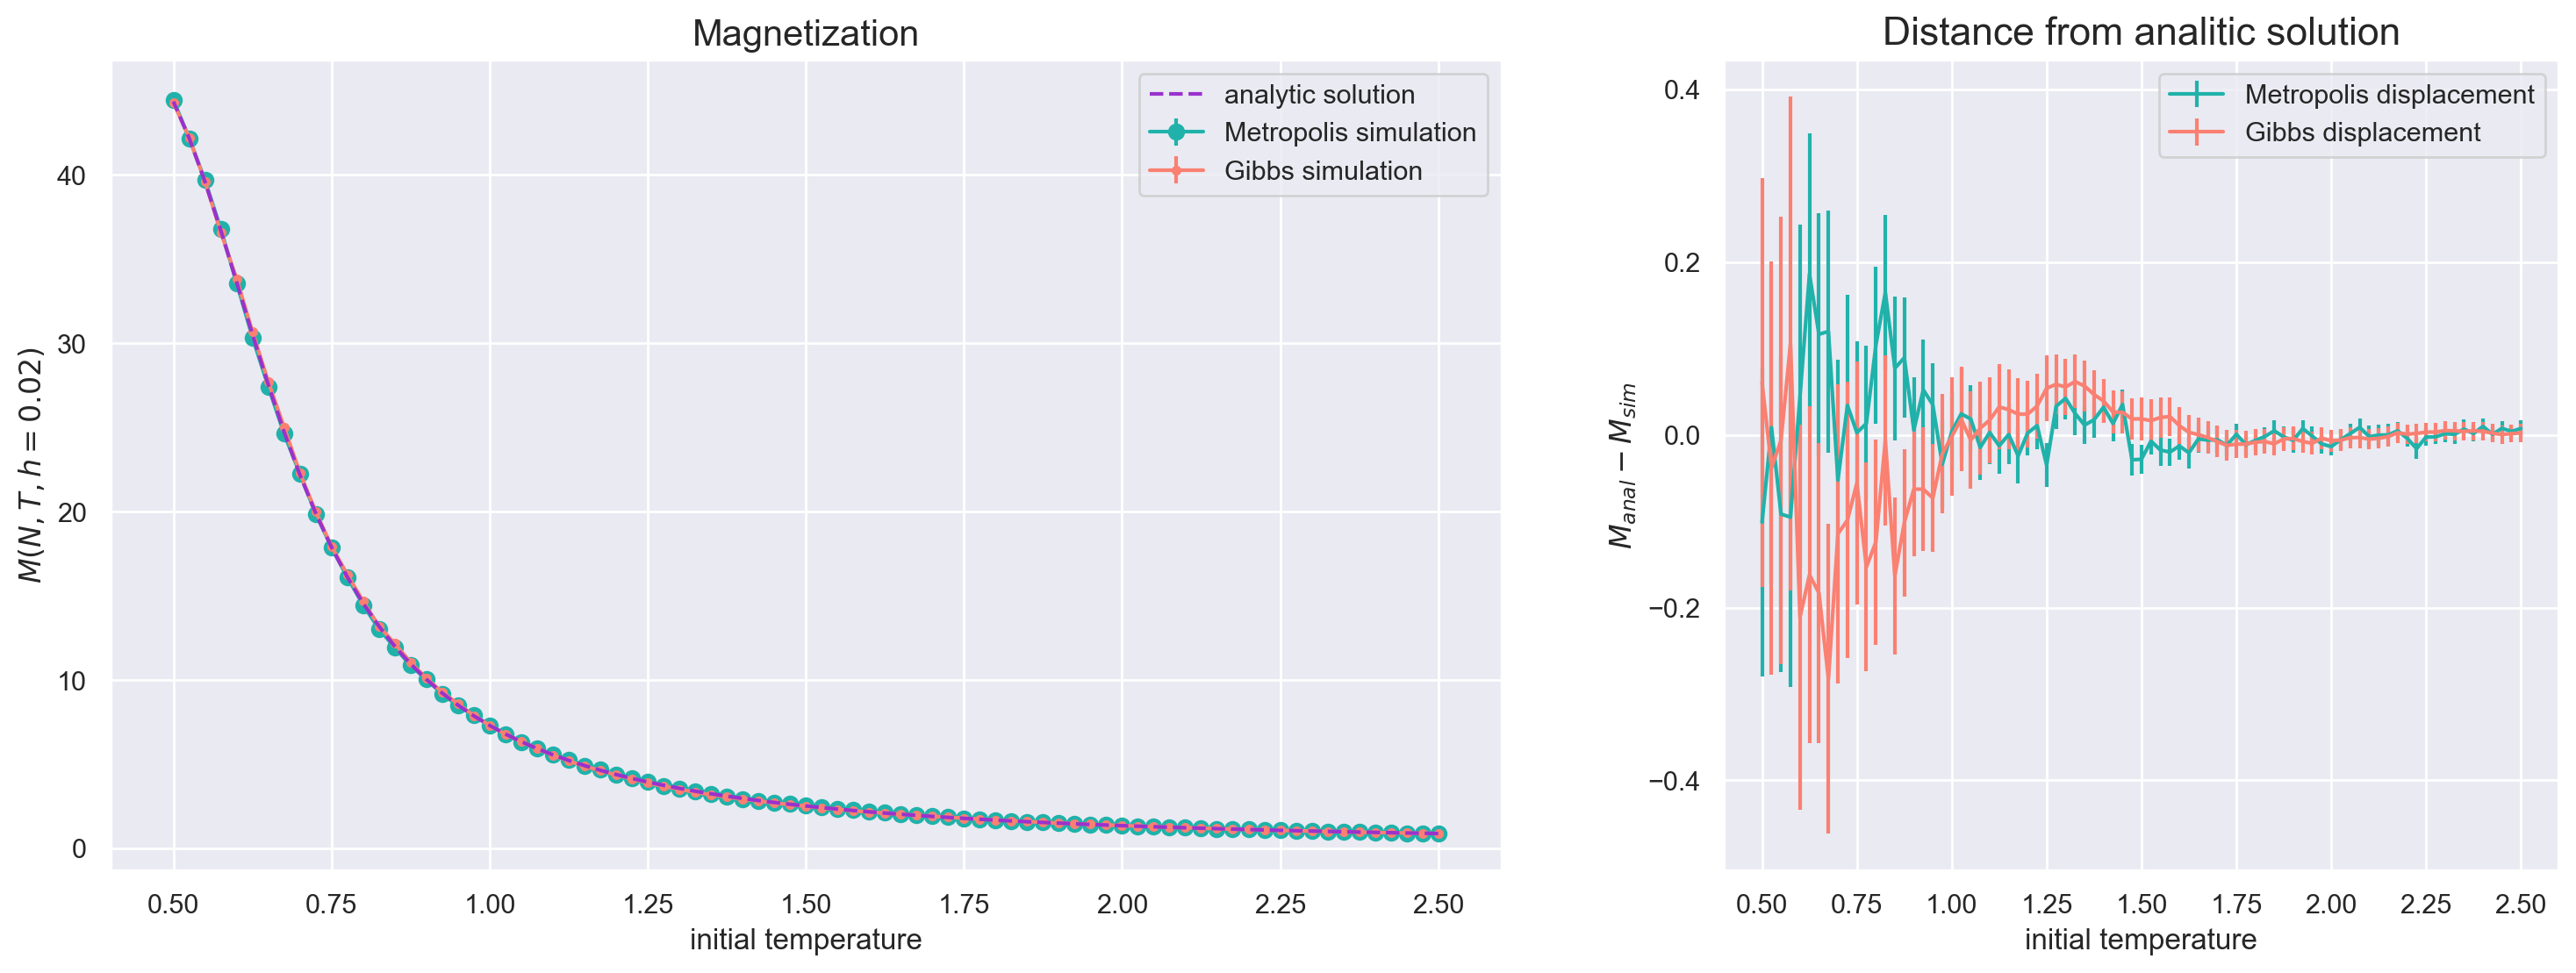

In [5]:
# magnetization

final_value_MET, error_MET = np.loadtxt('./6.1/_OUTPUT/METROPOLIS/magnetization_0.02.dat', skiprows=1, unpack = True, usecols=(1, 2))
final_value_GIB, error_GIB = np.loadtxt('./6.1/_OUTPUT/GIBBS/magnetization_0.02.dat', skiprows=1, unpack = True, usecols=(1, 2))

h=0.02 #external field
b = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th
l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
Z = l1**Ns + l2**Ns
M = 50*(np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
        + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)

# Create a figure with 2 subplots, using width ratios of [2, 1.3] for the subplots
fig, axs = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [2, 1.2]}, figsize=(18,6))

# Plot data in the first subplot
axs[0].errorbar(T, final_value_MET, yerr=error_MET,
					 color=colors[0], marker='o', label="Metropolis simulation")
axs[0].errorbar(T, final_value_GIB, yerr=error_GIB,
					 color=colors[1], marker='.', label="Gibbs simulation")
axs[0].grid(True)  # Add grid lines to the plot
axs[0].set_xlabel('initial temperature', fontsize=12)
axs[0].set_ylabel(r'$M(N,T,h=0.02)$', fontsize=12)
axs[0].set_title('Magnetization', fontsize=15)

# Plot theoretical line
axs[0].plot(T, M, color=colors[2], label="analytic solution", linestyle='--', zorder=10)
axs[0].legend()

# axs[0].set_xlim(0.2,0.4)

# Plot data in the second subplot
axs[1].set_title(r'Distance from analitic solution', size = 16)
axs[1].errorbar(T, M - final_value_MET, color=colors[0], yerr=error_MET, label="Metropolis displacement")
axs[1].errorbar(T, M - final_value_GIB, color=colors[1], yerr=error_GIB, label="Gibbs displacement")
# style second subplot
axs[1].set_xlabel('initial temperature', size = 12)
axs[1].set_ylabel(r'$M_{anal}-M_{sim}$', size = 12)
axs[1].grid(True)
axs[1].legend()

# Show the plot
plt.show()

In general from the graphs shown we can see that the results obtained with the two sampling methods are in good agreement with the exact curves. The Metropolis algorithm seems to have a slightly higher variance compared to the Gibbs algorithm, which is expected since the Metropolis algorithm has a rejection rate that can be higher than the Gibbs algorithm. However, the results obtained with the Metropolis algorithm are still in good agreement with the exact curves. Thus both simulations proved to be successful in reproducing the macroscopic quantities of the 1D Ising model.

Another observation to be made is that the fluctuations for all observed quantities increased significantly at low temperatures, which is expected since the system is more ordered at low temperatures, so even slight changes in spins configurations will affect the observed quantities more significantly.